## Initial Exploration

In [12]:
using Plots, CSV, DataFrames, Pkg, Statistics, LaTeXStrings
include("../../src/canonical_two_stage_model_with_division_functions.jl")
include("../../src/model_with_ribosomes_functions.jl")
include("../../src/simple_canonical_model_functions.jl")

Main.SimpleCanonicalModel

In [15]:
df = DataFrame(CSV.File("../../data/experimental_data_sanitised.csv"))
dropmissing!(df)
df[12,:]

DataFrameRow
 Row │ id             pNumber    mNumber  alpha    beta     mHalfLife  pHalfLi ⋯
     │ String         Float64    Float64  Float64  Float64  Float64    Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
  12 │ IPI00555113.2  1.44141e7    408.9    24.37  1027.75      18.14     121. ⋯
                                                                1 column omitted

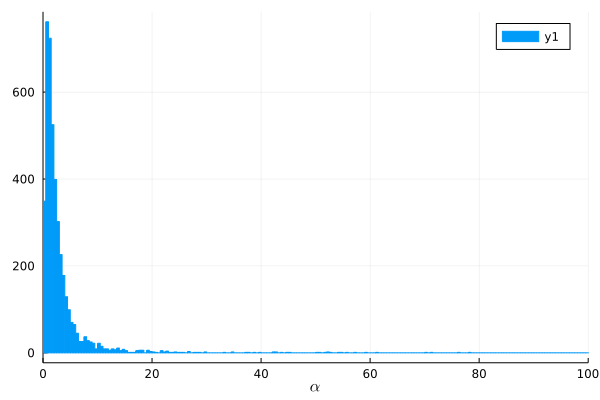

In [6]:
histogram(
    df[!, :alpha],
    xlims = (0, 100),
    xlabel = L"\alpha",
    linecolour=:match,
)

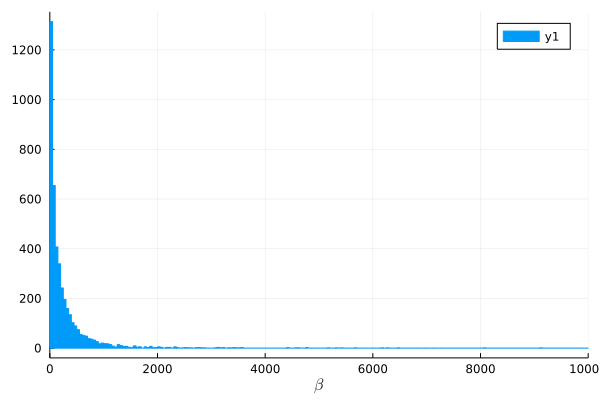

In [7]:
histogram(
    df[!, :beta],
    xlims=(0, 10000),
    xlabel=L"\beta",
    linecolour=:match,
)

In [16]:
histogram(
    df[!, :mNumber],
    xlims=(0,400),
    xlabel=L"\langle\langle m \rangle\rangle",
    ylabel="count",
    label=false,
    linecolour=:match,
)

savefig("../../data/schwanhausser/mRNA_copy_number.svg")

In [19]:
histogram(
    df[!, :pNumber],
    xlims=(0, 1.05e6),
    xlabel=L"\langle\langle p \rangle\rangle",
    ylabel="count",
    label=false,
    linecolour=:match,
)
savefig("../../data/schwanhausser/protein_copy_number.svg")

In [33]:
histogram(
    df[!, :mHalfLife],
    linecolour=:match,
    xlabel="mRNA Half Life",
    ylabel="count",
    label=false,
)
vline!(
    [27.5],
    label=:false,
    linewidth=1.5
)
annotate!(27.5, -25, text(L"T", 8))
savefig("../../data/schwanhausser/mRNA_half_life.svg")

In [34]:
histogram(
    df[!, :pHalfLife],
    xlims=(0,1000),
    linecolour=:match,
    label=false,
    xlabel="Protein Half Life",
    ylabel="Count",
)
vline!([27.5], label=false, linewidth=1.5)
annotate!(27.5, -35, text(L"T", 8))
savefig("../../data/schwanhausser/protein_half_life.svg")

In [30]:
function maxk(a, k)
    b = partialsortperm(a, 1:k, rev=true)
    return collect(zip(b, a[b]))
end
maxk(df[:, :pNumber], 5)
    

5-element Vector{Tuple{Int64, Float64}}:
 (1, 1.201243583e8)
 (3, 3.563217798e7)
 (2, 3.395867377e7)
 (11, 2.801024508e7)
 (7, 2.458552619e7)

alpha: 24.37
beta: 1027.75
gamma: 0.038210980185223


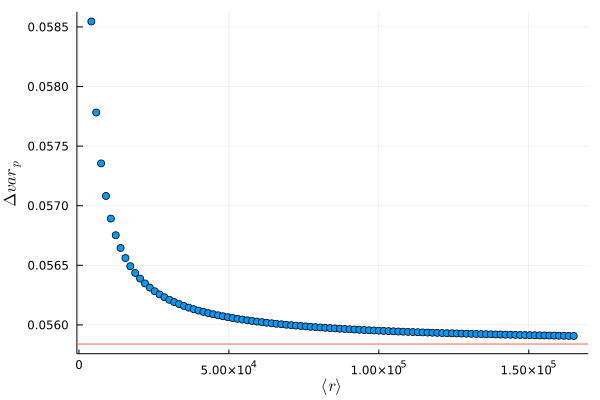

In [9]:
rho = LinRange(100, 4000.0, 100)
datum = df[12, :]
alpha = datum.alpha
beta2 = datum.beta
gamma = log(2)/datum.mHalfLife
println("alpha: $alpha")
println("beta: $beta2")
println("gamma: $gamma")
T = 27.5
y = []
for r in rho
    beta3 = 2*beta2/(3*r*T)
    p_var_2 = CanonicalTwoStageModel.p_var_time_av(alpha, beta2, gamma, T)
    p_var_3 = ModelWithRibosomes.p_var_time_av(alpha, beta3, gamma, r, T)
    append!(
        y,
        (p_var_3 - p_var_2)/p_var_3
    )
end
scatter(
    rho*3/2 * T, 
    y,
    ylabel=L"\Delta \rm{var}_p",
    xlabel=L"\langle r \rangle",
    label=:false,
    ms=4
)
hline!(
    [ModelWithRibosomes.limit_of_differences(alpha, beta2, gamma, T)],
    label=:false
)

In [10]:
function relative_difference_in_variance(alpha, beta2, gamma, rho, T)
    beta3 = 2*beta2/(3*rho*T)
    p_var_2 = CanonicalTwoStageModel.p_var_time_av(alpha, beta2, gamma, T)
    p_var_3 = ModelWithRibosomes.p_var_time_av(alpha, beta3, gamma, rho, T)
    return (p_var_3 - p_var_2)/p_var_3
end

relative_difference_in_variance (generic function with 1 method)

In [11]:
limits_of_difference = []
for x in eachrow(df)
    r = 5000000
    gamma = log(2)/x.mHalfLife
    append!(limits_of_difference, relative_difference_in_variance(x.alpha, x.beta, gamma, r, T))
end
histogram(
    limits_of_difference,
    xlims=(-0.05, 0.1),
    xlabel=L"\Delta \rm{var}_p",
    ylabel="count",
    linecolour=:match,
    label=false
)
savefig("../../data/schwanhausser/relative_differences.svg")

In [12]:
function limit_of_difference(df, r)
    limits_of_difference = []
    for x in eachrow(df)
        gamma = log(2)/x.mHalfLife
        append!(limits_of_difference, relative_difference_in_variance(x.alpha, x.beta, gamma, r, T))
    end
    return limits_of_difference
end

limit_of_difference (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/louis/projects/translation-kinetics/data/VarianceDiffConvergence.gif
└ @ Plots /home/louis/.julia/packages/Plots/sUjwv/src/animation.jl:104


Plots.AnimatedGif("/home/louis/projects/translation-kinetics/data/VarianceDiffConvergence.gif")
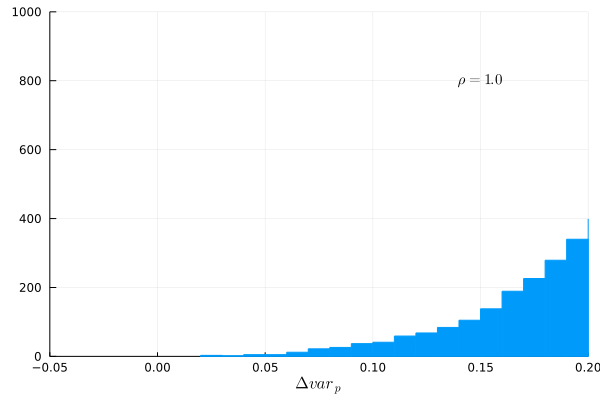

In [13]:
dr = 0.2
 
anim = @animate for r = 1:dr:50
    histogram(
        limit_of_difference(df, r),
        legend=false,
        xlabel=L"\Delta \rm{var}_p",
        xlims=(-0.05,0.2),
        ylims=(0, 1000),
        linecolour=:match
    )
    annotate!(0.15, 800, text(L"\rho=%$r", 10))
end
 
gif(anim, "../../data/VarianceDiffConvergence.gif", fps = 30)

## Calculating parameters from raw data

Given the mRNA and protein copy numbers and half lives it is quite easy to calculate the kinetic parameters.

In [14]:
model_1_df = copy(df)

4247×7 DataFrame
  Row │ id                                
      │ String                            
──────┼─────────────────────────────────────────────────────
    1 │ IPI00110850.1;IPI00473320.2;IPI0…
    2 │ IPI00470152.2;IPI00755353.2;IPI0…
    3 │ IPI00307837.6;IPI00831365.1;IPI0…
    4 │ IPI00124096.1;IPI00918751.1
    5 │ IPI00229517.5
    6 │ IPI00223713.5
    7 │ IPI00468203.3;IPI00605518.1;IPI0…
    8 │ IPI00131459.1;IPI00649586.1;IPI0…
    9 │ IPI00890117.1;IPI00848816.1;IPI0…
   10 │ IPI00224740.6;IPI00650039.1
   11 │ IPI00117352.1
  ⋮   │                 ⋮                  ⋮  ⋮  ⋮  ⋮  ⋮  ⋮
 4238 │ IPI00896576.2;IPI00896688.1
 4239 │ IPI00111639.3
 4240 │ IPI00875480.1;IPI00463549.3;IPI0…
 4241 │ IPI00849717.1
 4242 │ IPI00400214.3
 4243 │ IPI00553465.4
 4244 │ IPI00123119.4;IPI00762213.1
 4245 │ IPI00918105.1;IPI00756882.2;IPI0…
 4246 │ IPI00469221.5;IPI00230018.1;IPI0…
 4247 │ IPI00315032.9;IPI00230024.3
                             6 columns and 4226 rows omitted

In [15]:
names(model_1_df)

7-element Vector{String}:
 "id"
 "pNumber"
 "mNumber"
 "alpha"
 "beta"
 "mHalfLife"
 "pHalfLife"

In [16]:
model_1_df_altered = select(
    model_1_df,
    :pNumber,
    :mNumber,
    [:mHalfLife] => ((mHalfLife) -> log(2)./mHalfLife) => :gamma,
    [:pHalfLife] => ((pHalfLife) -> log(2)./pHalfLife) => :delta,
)

select!(
    model_1_df_altered,
    :pNumber,
    :mNumber,
    :gamma,
    :delta,
    [:gamma, :mNumber] => ((gamma, mNumber) -> gamma.*mNumber) => :alpha,
)

select!(
    model_1_df_altered,
    :pNumber,
    :mNumber,
    :gamma,
    :delta,
    :alpha,
    [:alpha, :gamma, :delta, :pNumber] => ((alpha, gamma, delta, pNumber) -> gamma.*delta.*pNumber./alpha) => :beta,
)

select!(
    model_1_df_altered,
    :pNumber,
    :mNumber,
    :gamma,
    :delta,
    :alpha,
    :beta,
    [:alpha, :gamma] => ((alpha, gamma) -> SimpleCanonicalModel.m_var(alpha, gamma)) =>  :varM,
    [:alpha, :beta, :gamma, :delta] => ((alpha, beta, gamma, delta) -> SimpleCanonicalModel.p_var(alpha, beta, gamma, delta)) => :varP,
)

4247×8 DataFrame
  Row │ pNumber       mNumber  gamma      delta       alpha       beta         ⋯
      │ Float64       Float64  Float64    Float64     Float64     Float64      ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    1.20124e8  2187.76  0.0618329  0.0111942   135.276        614.647   ⋯
    2 │    3.39587e7    12.79  0.0675582  0.0617228     0.864069  163880.0
    3 │    3.56322e7  3229.54  0.0396084  0.0054868   127.917         60.537
    4 │    2.43716e7  1825.51  0.0436216  0.00474141   79.6317        63.3005
    5 │    2.41904e7  2247.05  0.050301   0.00441636  113.029         47.5439  ⋯
    6 │    1.80489e7     4.31  0.180038   0.0121647     0.775965   50942.0
    7 │    2.45855e7   630.69  0.0459038  0.00297974   28.9511       116.156
    8 │    1.71408e7   145.85  0.0485058  0.00399025    7.07456      468.95
    9 │    2.07284e7   729.82  0.0481687  0.0102994    35.1545       292.523   ⋯
   10 │    2.03004e7   692.25  0.0432137  0.00598935   29.9147       175.639
   11 │    2.80102e7   395.89  0.0504841  0.00508433   19.9862       359.73
  ⋮   │      ⋮           ⋮         ⋮          ⋮           ⋮              ⋮     ⋱
 4238 │  172.55          2.82  0.119097   0.055143      0.335855       3.37409
 4239 │  120.65          5.07  0.0640025  0.013805      0.324493       0.32851 ⋯
 4240 │  217.23          7.12  0.18633    0.0118285     1.32667        0.36088
 4241 │  138.27          6.24  0.0950819  0.148108      0.593311       3.28188
 4242 │  135.27        119.57  0.0689699  0.0059294     8.24673        0.00670
 4243 │ 1205.26         11.04  0.125343   0.0636499     1.38379        6.94879 ⋯
 4244 │   61.37          2.59  0.063359   0.0435121     0.1641         1.03102
 4245 │  265.32         11.87  0.0694536  0.0671004     0.824415       1.49984
 4246 │  212.69          5.36  0.0392052  0.0169308     0.21014        0.67183
 4247 │  215.87          7.84  0.143212   0.0513823     1.12278        1.41478 ⋯
                                                 3 columns and 4226 rows omitted

In [17]:
T = 27.5
model_2_df = copy(df)
select!(
    model_2_df,
    :pNumber,
    :mNumber,
    [:mHalfLife] => ((mHalfLife) -> log(2)./mHalfLife) => :gamma,
    [:pHalfLife] => ((pHalfLife) -> log(2)./pHalfLife) => :delta,
)

select!(
    model_2_df,
    :pNumber,
    :mNumber,
    :gamma,
    :delta,
    [:gamma, :mNumber] => (ByRow((gamma, mNumber) -> CanonicalTwoStageModel.alpha(mNumber, gamma, T))) => :alpha,
)

select!(
    model_2_df,
    :pNumber,
    :mNumber,
    :alpha,
    :gamma,
    :delta,
     [:alpha, :gamma, :pNumber] => (ByRow((alpha, gamma, pNumber) -> CanonicalTwoStageModel.beta(pNumber, alpha, gamma, T))) => :beta,
)

select!(
    model_2_df,
    :pNumber,
    :mNumber,
    :gamma,
    :delta,
    :alpha,
    :beta,
    [:alpha, :gamma] => (ByRow((alpha, gamma) -> CanonicalTwoStageModel.m_var_time_av(alpha, gamma, T))) =>  :varM,
    [:alpha, :beta, :gamma] => (ByRow((alpha, beta, gamma) -> CanonicalTwoStageModel.p_var_time_av(alpha, beta, gamma, T))) => :varP,
)

4247×8 DataFrame
  Row │ pNumber       mNumber  gamma      delta       alpha       beta         ⋯
      │ Float64       Float64  Float64    Float64     Float64     Float64      ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    1.20124e8  2187.76  0.0618329  0.0111942   183.924       1375.72    ⋯
    2 │    3.39587e7    12.79  0.0675582  0.0617228     1.14653    66490.0
    3 │    3.56322e7  3229.54  0.0396084  0.0054868   201.823        276.969
    4 │    2.43716e7  1825.51  0.0436216  0.00474141  121.182        335.03
    5 │    2.41904e7  2247.05  0.050301   0.00441636  163.726        270.002   ⋯
    6 │    1.80489e7     4.31  0.180038   0.0121647     0.862787  103884.0
    7 │    2.45855e7   630.69  0.0459038  0.00297974   43.2625       978.057
    8 │    1.71408e7   145.85  0.0485058  0.00399025   10.3729      2948.02
    9 │    2.07284e7   729.82  0.0481687  0.0102994    51.6661       712.47    ⋯
   10 │    2.03004e7   692.25  0.0432137  0.00598935   45.6794       735.935
   11 │    2.80102e7   395.89  0.0504841  0.00508433   28.9159      1774.49
  ⋮   │      ⋮           ⋮         ⋮          ⋮           ⋮             ⋮      ⋱
 4238 │  172.55          2.82  0.119097   0.055143      0.394994       1.52524
 4239 │  120.65          5.07  0.0640025  0.013805      0.436936       0.59612 ⋯
 4240 │  217.23          7.12  0.18633    0.0118285     1.46965        0.75652
 4241 │  138.27          6.24  0.0950819  0.148108      0.727061       0.55352
 4242 │  135.27        119.57  0.0689699  0.0059294    10.883          0.02832
 4243 │ 1205.26         11.04  0.125343   0.0636499     1.61414        2.71988 ⋯
 4244 │   61.37          2.59  0.063359   0.0435121     0.221586       0.59360
 4245 │  265.32         11.87  0.0694536  0.0671004     1.08597        0.55965
 4246 │  212.69          5.36  0.0392052  0.0169308     0.332867       0.99615
 4247 │  215.87          7.84  0.143212   0.0513823     1.28422        0.68496 ⋯
                                                 3 columns and 4226 rows omitted

In [18]:
model_3_df = copy(model_2_df)

select!(
    model_3_df,
    :pNumber,
    :mNumber,
    :alpha,
    :beta => :beta2,
    :gamma,
    :delta,
    [:alpha, :beta, :gamma] => (ByRow((alpha, beta, gamma) -> ModelWithRibosomes.limit_of_differences(alpha, beta, gamma, T))) => :relative_diff,
)


4247×7 DataFrame
  Row │ pNumber       mNumber  alpha       beta2          gamma      delta     ⋯
      │ Float64       Float64  Float64     Float64        Float64    Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    1.20124e8  2187.76  183.924       1375.72      0.0618329  0.0111942 ⋯
    2 │    3.39587e7    12.79    1.14653    66490.0       0.0675582  0.0617228
    3 │    3.56322e7  3229.54  201.823        276.969     0.0396084  0.0054868
    4 │    2.43716e7  1825.51  121.182        335.03      0.0436216  0.0047414
    5 │    2.41904e7  2247.05  163.726        270.002     0.050301   0.0044163 ⋯
    6 │    1.80489e7     4.31    0.862787  103884.0       0.180038   0.0121647
    7 │    2.45855e7   630.69   43.2625       978.057     0.0459038  0.0029797
    8 │    1.71408e7   145.85   10.3729      2948.02      0.0485058  0.0039902
    9 │    2.07284e7   729.82   51.6661       712.47      0.0481687  0.0102994 ⋯
   10 │    2.03004e7   692.25   45.6794       735.935     0.0432137  0.0059893
   11 │    2.80102e7   395.89   28.9159      1774.49      0.0504841  0.0050843
  ⋮   │      ⋮           ⋮         ⋮             ⋮            ⋮          ⋮     ⋱
 4238 │  172.55          2.82    0.394994       1.52524   0.119097   0.055143
 4239 │  120.65          5.07    0.436936       0.59612   0.0640025  0.013805  ⋯
 4240 │  217.23          7.12    1.46965        0.756527  0.18633    0.0118285
 4241 │  138.27          6.24    0.727061       0.553527  0.0950819  0.148108
 4242 │  135.27        119.57   10.883          0.028327  0.0689699  0.0059294
 4243 │ 1205.26         11.04    1.61414        2.71988   0.125343   0.0636499 ⋯
 4244 │   61.37          2.59    0.221586       0.593603  0.063359   0.0435121
 4245 │  265.32         11.87    1.08597        0.559657  0.0694536  0.0671004
 4246 │  212.69          5.36    0.332867       0.996153  0.0392052  0.0169308
 4247 │  215.87          7.84    1.28422        0.684963  0.143212   0.0513823 ⋯
                                                 2 columns and 4226 rows omitted

In [19]:
plot(
    df[!, :beta],
    label="Schwanhausser 2011",
    seriestype=:histogram,
    linewidth=0,
    alpha=0.5,
    linecolour=:match,
)

plot!(
    model_1_df[!, :beta],
    xlimits=(0,1000),
    label="Model 1",
    seriestype=:histogram,
    xlabel=L"\beta",
    ylabel="count",
    linewidth=0,
    alpha=0.5,
    linecolour=:match,
)

plot!(
    model_2_df[!, :beta],
    label="Model 2",
    seriestype=:histogram,
    linewidth=0,
    alpha=0.5,
    linecolour=:match,
)


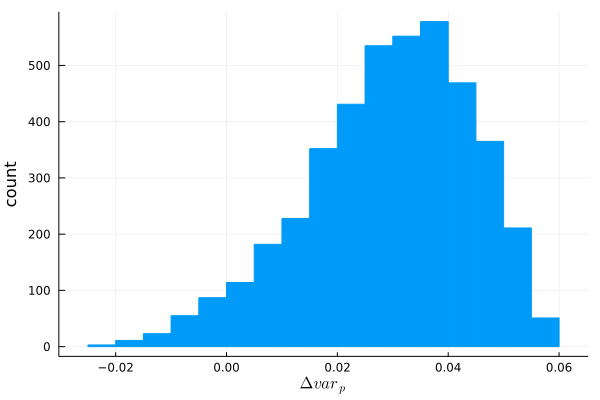

In [20]:
histogram(
    model_3_df[!, :relative_diff],
    legend=false,
    xlabel=L"\Delta \rm{var}_p",
    ylabel="count",
    linecolour=:match,
)

In [21]:
model_3_df[model_3_df[!, :relative_diff] .< 0, :]

179×7 DataFrame
 Row │ pNumber         mNumber  alpha     beta2         gamma      delta       ⋯
     │ Float64         Float64  Float64   Float64       Float64    Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      1.64824e6     2.88  0.195879  14359.8       0.0453037  0.0103162   ⋯
   2 │ 962443.0           2.24  0.258176  10734.3       0.0937953  0.00766162
   3 │      3.99949e5     2.45  0.319257   4072.75      0.109157   0.00496133
   4 │      2.42226e5     2.19  0.455326   2742.31      0.187845   0.00746845
   5 │      1.75127e5     2.99  0.188719   1470.24      0.0402524  0.0215799   ⋯
   6 │      1.28669e5     2.7   0.256456   1192.82      0.0730397  0.00631512
   7 │      1.93252e5     1.88  0.211038   2568.81      0.0907261  0.010243
   8 │      1.41394e5     2.47  0.152291   1437.13      0.038745   0.0108883
   9 │  90006.8           2.63  0.30215     855.029     0.0934161  0.0308065   ⋯
  10 │      1.11442e5     3.01  0.220825    928.538     0.0508172  0.00552793
  11 │      1.10449e5     3.28  0.344744    842.06      0.0834112  0.0380641
  ⋮  │       ⋮            ⋮        ⋮           ⋮            ⋮          ⋮       ⋱
 170 │   1360.07          2.93  0.297784     11.6115    0.0798557  0.00560209
 171 │    529.02          2.54  0.290256      5.20384   0.0927908  0.0185086   ⋯
 172 │    456.17          3.03  0.31182       3.76554   0.0811648  0.0219837
 173 │    483.97          3.78  0.229053      3.21459   0.0376506  0.00260827
 174 │    386.44          2.15  0.149553      4.50928   0.0468976  0.00988798
 175 │    143.32          3.47  0.254447      1.03585   0.05078    0.00770934  ⋯
 176 │     56.66          3.33  0.371505      0.425233  0.0900191  0.0538158
 177 │    290.97          2.26  0.269873      3.21529   0.0980406  0.0126187
 178 │    172.55          2.82  0.394994      1.52524   0.119097   0.055143
 179 │     61.37          2.59  0.221586      0.593603  0.063359   0.0435121   ⋯
                                                   1 column and 158 rows omitted

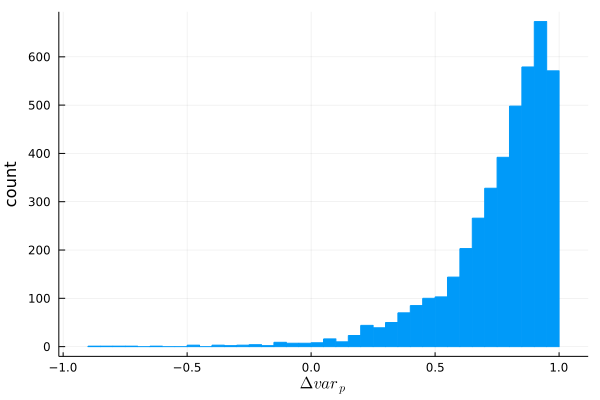

In [24]:
plot(
    (-model_1_df_altered[!, :varP]+ model_2_df[!, :varP]) ./ model_2_df[!, :varP],
    label=false,
    seriestype=:histogram,
    linecolour=:match,
    xlabel=L"\Delta \rm{var}_p",
    ylabel="count",
)


In [23]:
 (-model_1_df_altered[!, :varP]+ model_2_df[!, :varP]) ./ model_2_df[!, :varP]

4247-element Vector{Float64}:
  0.9982986317687866
  0.36957631825142256
  0.999079195470329
  0.9986909681783249
  0.9991248552470223
  0.7861494505677987
  0.9976629738066324
  0.9878344902487092
  0.9941585243308656
  0.9957426454633335
  0.9944508606651485
  0.9923437970186816
  0.9956096355238262
  ⋮
  0.8132164274687221
  0.2635296566592276
 -0.1323633518744413
  0.5511783270344881
  0.790362993695406
 -0.33429603908903743
  0.8402964275143733
  0.44247656489531095
 -0.1564929064525489
  0.295253461427461
  0.4043827848038596
  0.4004815755111762